In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
import pandas as pd

def visualize_aqi_poverty_correlation(air_df, output_filename='aqi_poverty_correlation.png'):
    """
    Create an advanced visualization of the correlation between Air Quality Index and poverty
    
    Parameters:
    -----------
    air_df : DataFrame
        DataFrame containing both AQI and poverty_index data
    output_filename : str
        Filename to save the output visualization
    """
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # Calculate correlation and regression
    correlation = air_df['AQI'].corr(air_df['poverty_index'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        air_df['poverty_index'], air_df['AQI'])

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
        18, 8), gridspec_kw={'width_ratios': [1.5, 1]})

    # 1. Create an enhanced scatter plot with regression line
    # Add district information through color
    districts = air_df['District'].unique()
    district_colors = plt.cm.tab20(np.linspace(0, 1, len(districts)))
    district_color_map = dict(zip(districts, district_colors))

    # Add scatter plot with district coloring
    for district in districts:
        district_data = air_df[air_df['District'] == district]
        ax1.scatter(district_data['poverty_index'], district_data['AQI'],
                    label=district, color=district_color_map[district],
                    s=60, alpha=0.7, edgecolors='k', linewidth=0.5)

    # Add regression line
    x_line = np.linspace(air_df['poverty_index'].min(),
                         air_df['poverty_index'].max(), 100)
    y_line = intercept + slope * x_line
    ax1.plot(x_line, y_line, color='red', linestyle='--', linewidth=2)

    # Calculate confidence interval
    conf = 0.95
    n = len(air_df)
    x_mean = air_df['poverty_index'].mean()
    x_std = air_df['poverty_index'].std()

    # Add shaded confidence interval
    t_val = stats.t.ppf((1 + conf) / 2, n - 2)
    s_err = std_err * np.sqrt(1/n + (x_line - x_mean)**2 / (n * x_std**2))
    ax1.fill_between(x_line, y_line - t_val * s_err, y_line + t_val * s_err,
                     color='red', alpha=0.2, label=f'{conf*100:.0f}% Confidence Interval')

    # Add equation and R² value
    # eq_text = f'AQI = {slope:.2f} × Poverty Index + {intercept:.2f}'
    # r2_text = f'R² = {r_value**2:.2f}, p = {p_value:.4f}'
    # stats_text = f'{eq_text}\n{r2_text}'
    # ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, fontsize=12,
    #          bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
    #          verticalalignment='top')
    




    # Customize plot
    ax1.set_xlabel('Poverty Index', fontsize=14)
    ax1.set_ylabel('Air Quality Index (AQI)', fontsize=14)
    ax1.set_title('Relationship Between Poverty and Air Quality', fontsize=16)
    ax1.grid(True, alpha=0.3)

    # Add legend with key districts (limit to top 5 for readability)
    top_districts = air_df.groupby('District')['AQI'].mean().nlargest(5).index
    handles, labels = ax1.get_legend_handles_labels()
    filtered_handles = [h for i, h in enumerate(
        handles) if labels[i] in top_districts or 'Confidence' in labels[i]]
    filtered_labels = [
        l for l in labels if l in top_districts or 'Confidence' in l]
    ax1.legend(filtered_handles, filtered_labels, title='Top Districts', loc='upper left',
               bbox_to_anchor=(1, 1), frameon=True)

    # 2. Create a hexbin plot to handle overplotting and show density
    hb = ax2.hexbin(air_df['poverty_index'], air_df['AQI'],
                    gridsize=15, cmap='viridis',
                    mincnt=1, bins='log')

    cb = fig.colorbar(hb, ax=ax2)
    cb.set_label('Log10(Count)')


    # plot correlation coefficient
    # Overlay regression line
    ax2.plot(x_line, y_line, color='red', linestyle='--', linewidth=2)

    # Customize plot
    ax2.set_xlabel('Poverty Index', fontsize=14)
    ax2.set_ylabel('Air Quality Index (AQI)', fontsize=14)
    ax2.set_title('Density of Observations', fontsize=16)
    ax2.grid(True, alpha=0.3)

#     # Add interpretive text
#     interp_text = f"""Key Findings:
# - There is a {'positive' if correlation > 0 else 'negative'} correlation (r = {correlation:.2f}) between poverty and air quality.
# - Statistical significance: {'Significant' if p_value < 0.05 else 'Not significant'} (p = {p_value:.4f})
# - For each 0.1 unit increase in poverty index, AQI changes by {slope*0.1:.2f} units.
# - Areas with {'higher' if correlation > 0 else 'lower'} poverty tend to have {'worse' if correlation > 0 and slope > 0 else 'better'} air quality.
# - This pattern suggests potential {"environmental justice concerns" if correlation > 0 and slope > 0 else "complex socioeconomic-environmental dynamics"}.
#     """

#     plt.figtext(0.5, 0.01, interp_text, ha='center', va='bottom', fontsize=12,
#                bbox=dict(facecolor='#f8f9fa', alpha=0.8, boxstyle='round,pad=0.5'))

    # Add title and data source
    plt.suptitle(
        'Air Quality and Poverty in Rwanda: Exploring the Relationship', fontsize=18, y=0.98)

    plt.figtext(0.98, 0.01, 'Data: Sentinel-5P TROPOMI (2020-2025) & Rwanda Census 2022',
                ha='right', fontsize=8, style='italic')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.subplots_adjust(wspace=0.25)

    # Show and save plot
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()

    return

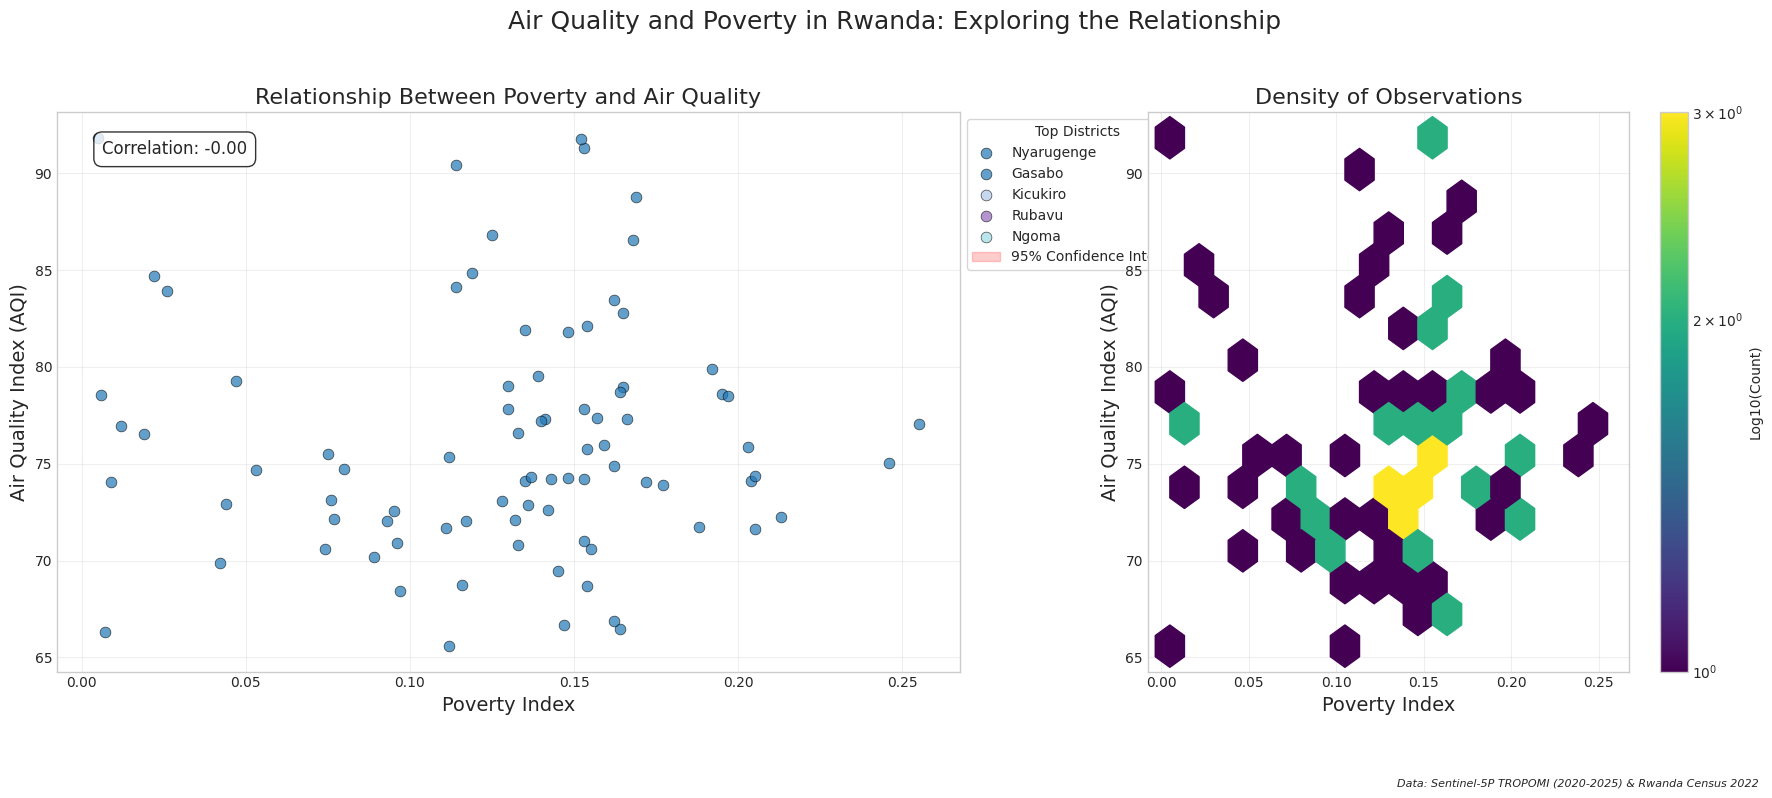

In [31]:
df = pd.read_csv('AQI_calculated.csv')
df = df[df['year'] == 2022]
# create_aqi_heatmap(sectors_df, df)
visualize_aqi_poverty_correlation(df)

In [14]:
def create_aqi_heatmap(sectors_gdf, air_df, output_filename='rwanda_aqi_heatmap.png'):
    """
    Create a heatmap visualization of Air Quality Index across Rwanda sectors.
    
    Parameters:
    -----------
    sectors_gdf : GeoDataFrame
        GeoDataFrame containing Rwanda sector boundaries
    air_df : DataFrame
        DataFrame containing AQI data with sector identifiers
    output_filename : str
        Filename to save the output map
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    
    # Merge the data with sector geometries
    map_data = sectors_gdf.merge(air_df[['Sect_ID', 'AQI']], on='Sect_ID', how='inner')
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create the heatmap with a sequential colormap
    map_data.plot(column='AQI', 
                  cmap='YlOrRd',  # Yellow-Orange-Red colormap
                  legend=True,
                  ax=ax,
                  legend_kwds={
                      'label': 'Air Quality Index',
                      'orientation': 'horizontal',
                      'shrink': 0.5,
                      'pad': 0.01
                  })
    
    # Add province boundaries
    province_boundaries = sectors_gdf.dissolve(by='Province')
    province_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.5)
    
    # Add district boundaries
    district_boundaries = sectors_gdf.dissolve(by='District')
    district_boundaries.boundary.plot(ax=ax, color='gray', linewidth=0.8, linestyle=':')
    
    # Customize the map
    ax.set_title('Air Quality Index across Rwanda Sectors', fontsize=16)
    ax.set_axis_off()
    
    # Add north arrow
    x, y, arrow_length = 0.05, 0.95, 0.07
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=1, headwidth=8),
                ha='center', va='center', fontsize=12,
                xycoords=ax.transAxes)
    
    # Add data source
    plt.figtext(0.5, 0.01, 
                'Data Source: Sentinel-5P TROPOMI satellite data (2020-2025)',
                ha='center', fontsize=10, style='italic')
    
    # Adjust layout
    plt.tight_layout()
    
    # Display and save the map
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return

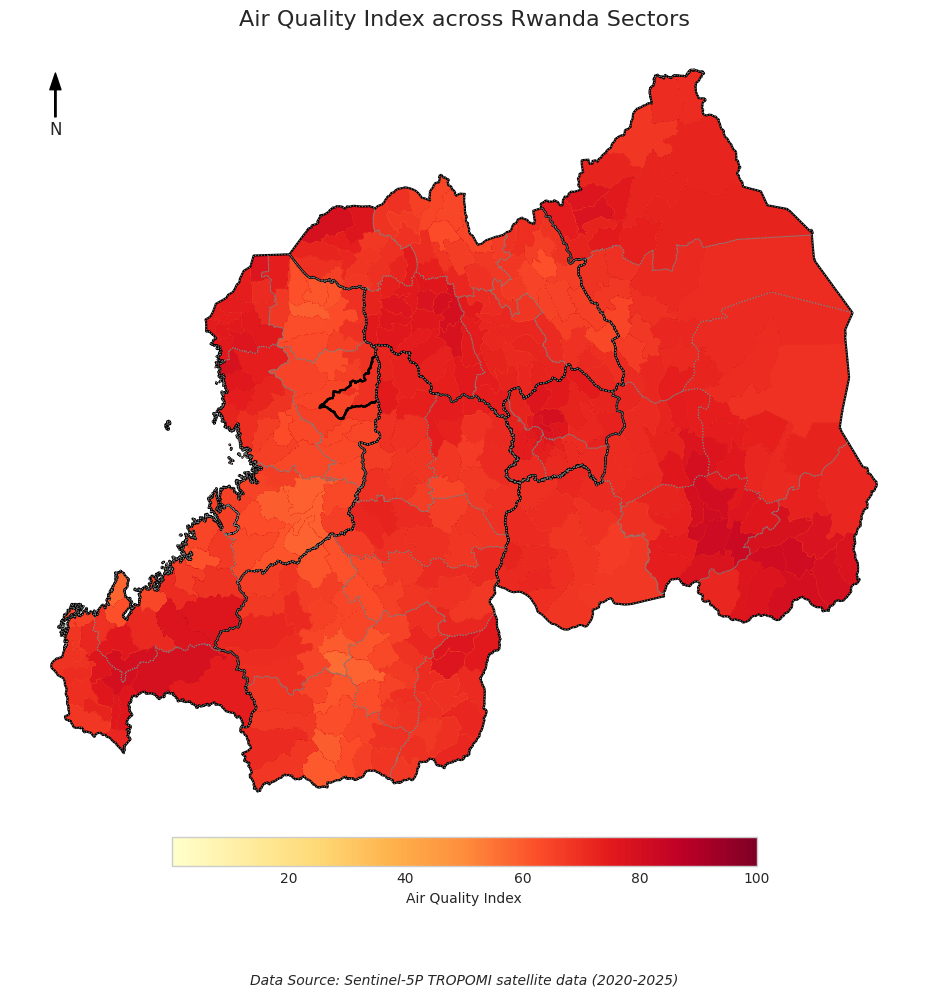

In [ ]:
import geopandas as gpd

sectors_df = gpd.read_file('rwa_sector/Sector.shp')

# Filter out years and only include 2022 data
df = pd.read_csv('AQI_calculated.csv')
df = df[df['year'] == 2022]
create_aqi_heatmap(sectors_df, df)

In [23]:
def create_correlation_heatmap(sectors_gdf, air_df, output_filename='poverty_aqi_correlation_heatmap.png'):
    """
    Create a heatmap visualization highlighting correlation between poverty index and AQI.
    
    Parameters:
    -----------
    sectors_gdf : GeoDataFrame
        GeoDataFrame containing Rwanda sector boundaries
    air_df : DataFrame
        DataFrame containing both AQI and poverty_index data with sector identifiers
    output_filename : str
        Filename to save the output map
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap
    
    # Calculate correlation score for each sector
    # A positive product means both values are above or below average (correlated)
    # A negative product means one is above while the other is below average (anti-correlated)
    air_df['AQI_z'] = (air_df['AQI'] - air_df['AQI'].mean()) / air_df['AQI'].std()
    air_df['poverty_z'] = (air_df['poverty_index'] - air_df['poverty_index'].mean()) / air_df['poverty_index'].std()
    air_df['correlation_score'] = air_df['AQI_z'] * air_df['poverty_z']
    
    # Merge the data with sector geometries
    map_data = sectors_gdf.merge(air_df[['Sect_ID', 'correlation_score', 'AQI', 'poverty_index']], 
                                on='Sect_ID', how='inner')
    
    # Create a custom diverging colormap from blue to white to red
    # - Blue: negative correlation (high AQI, low poverty OR low AQI, high poverty)
    # - White: no correlation
    # - Red: positive correlation (high AQI, high poverty OR low AQI, low poverty)
    colors_list = ['#1a53a4', '#6facd9', '#e8f0fb', '#ffffff', '#fddbcf', '#fc9272', '#de2d26']
    correlation_cmap = LinearSegmentedColormap.from_list('correlation_cmap', colors_list, N=256)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create the heatmap
    vmin, vmax = -np.abs(map_data['correlation_score']).max(), np.abs(map_data['correlation_score']).max()
    map_data.plot(column='correlation_score', 
                  cmap=correlation_cmap,
                  legend=True,
                  ax=ax,
                  vmin=vmin, vmax=vmax,  # Center colormap at zero
                  legend_kwds={
                      'label': 'AQI-Poverty Correlation',
                      'orientation': 'horizontal',
                      'shrink': 0.5,
                      'pad': 0.01,
                      'extend': 'both'
                  })
    
    # Add province boundaries
    province_boundaries = sectors_gdf.dissolve(by='Province')
    province_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.5)
    
    # Add district boundaries
    district_boundaries = sectors_gdf.dissolve(by='District')
    district_boundaries.boundary.plot(ax=ax, color='gray', linewidth=0.8, linestyle=':')
    
    # Calculate overall correlation for title
    overall_corr = air_df['AQI'].corr(air_df['poverty_index'])
    
    # Customize the map
    ax.set_title(f'Correlation Between Air Quality Index and Poverty\nOverall Correlation: {overall_corr:.2f}', 
                fontsize=16)
    ax.set_axis_off()
    
    # # Add explanation text
    # explanation_text = """
    # Color Interpretation:
    # • Dark Red: Strong positive correlation (high poverty, high AQI or low poverty, low AQI)
    # • Dark Blue: Strong negative correlation (high poverty, low AQI or low poverty, high AQI)
    # • White: No correlation between poverty and air quality
    
    # This map highlights areas where environmental and socioeconomic challenges coincide,
    # revealing potential environmental justice concerns.
    # """
    
    # plt.figtext(0.15, 0.15, explanation_text, fontsize=10,
    #            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add north arrow
    # x, y, arrow_length = 0.05, 0.95, 0.07
    # ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
    #             arrowprops=dict(facecolor='black', width=1, headwidth=8),
    #             ha='center', va='center', fontsize=12,
    #             xycoords=ax.transAxes')
    
    # Add data source
    plt.figtext(0.5, 0.01, 
                'Data Sources: Sentinel-5P TROPOMI (2020-2025) & Rwanda Census 2022',
                ha='center', fontsize=10, style='italic')
    
    # Adjust layout
    plt.tight_layout()
    
    # Display and save the map
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return map_data

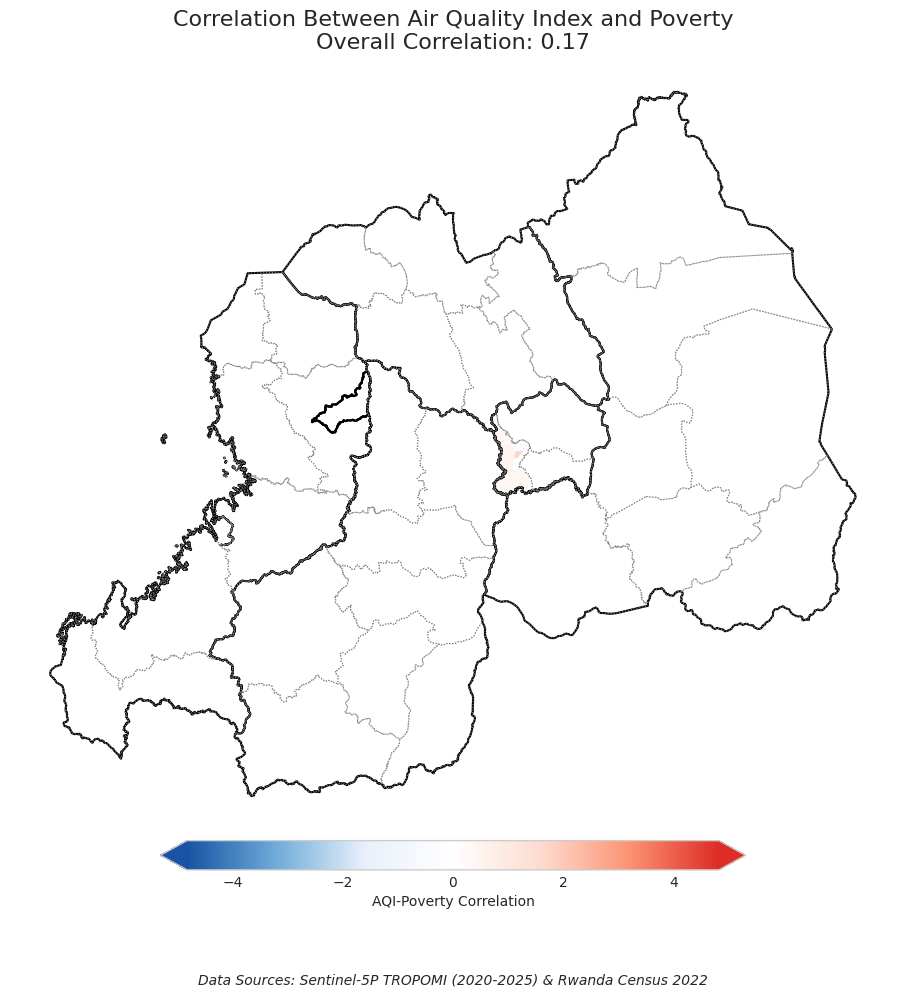

Number of sectors with very high positive correlation: 31
   Sect_ID  correlation_score        AQI  poverty_index
0   1101.0           1.606838  50.179203          0.010
2   1101.0           2.069145  38.089337          0.059
3   1101.0           2.413716  43.948169          0.015
5   1101.0           2.247773  46.125042          0.007
6   1101.0           3.565762  36.699960          0.010


In [24]:
# Example call
correlation_map_data = create_correlation_heatmap(sectors_df, df)

# You can also use the returned data for additional analysis
high_correlation_sectors = correlation_map_data[correlation_map_data['correlation_score'] > 1.5]
print(
    f"Number of sectors with very high positive correlation: {len(high_correlation_sectors)}")
print(high_correlation_sectors[[
      'Sect_ID', 'correlation_score', 'AQI', 'poverty_index']].head())